# Part 4: Manual Homography + Sticthing

### 1.Load im01.jpg and im02.jpg. Let the user to choose 4 points on im01.jpg and 4 points on im02.jpg 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import random as rm
import math
import cv2
from tkinter import *
from tkinter import messagebox
from PIL import Image, ImageTk

In [2]:
# the interchange of window axis to image axis
event2canvas = lambda e, c: (c.canvasx(e.x), c.canvasy(e.y))

#function to be called when mouse is clicked
def printcoords(event):
    #outputting x and y coords to console
    cx, cy = event2canvas(event, canvas)
    click = [event.y,event.x,cy,cx]
    print ("(%d, %d) / (%d, %d)" % (event.y,event.x,cy,cx))
    points.append(click)
    i = len(points)
    canvas.create_text(300+i*50, 670, text="(%d,%d)"%(event.y,event.x),font=("Arial",10))

In [3]:
# build a window object
root = Tk()

#box for points
points=[]

#size of the window
root.geometry("900x700")
root.title("CA1 Part4")
canvas=Canvas(root,bg='white',width=900,height=700)
canvas.pack()

#adding the image
img_im1 = Image.open('im01.jpg')
img_im1_photo = ImageTk.PhotoImage(img_im1)
img_im2 = Image.open('im02.jpg')
img_im2_photo = ImageTk.PhotoImage(img_im2)

Im = canvas.create_image(0,0,image=img_im1_photo,anchor=NW)
canvas.config(scrollregion=canvas.bbox(ALL))
Tx = canvas.create_text(200, 620, text="You need to click 4 points on im1",font=("Arial",20))
canvas.create_text(180, 670, text="The position of the points:",font=("Arial",20))

#mouseclick event
canvas.bind("<ButtonPress-1>",printcoords)

# set button event
def change_img():
    canvas.itemconfig(Im,image=img_im2_photo) 
    canvas.itemconfig(Tx,text="You need to click 4 points on im2")

# set button 
button = Button(root, text='Change to im2', command=change_img)  
button.place(x=750, y=650)

# start
root.mainloop()

(231, 323) / (228, 320)
(227, 400) / (224, 397)
(327, 500) / (324, 497)
(335, 563) / (332, 560)
(250, 23) / (247, 20)
(249, 119) / (246, 116)
(350, 225) / (347, 222)
(354, 278) / (351, 275)


### 2.Compute the homograhy matrix, and stitch the images together using the computed homography matrix and show the result:

In [4]:
# homography computing
def hmat(points):
    A = np.zeros([8,9])
    b = []
    for i in range(0,4):
        h1_x = points[i][2]
        h1_y = points[i][3]
        h2_x = points[i+4][2]
        h2_y = points[i+4][3]
        A[2*i][:] = [h1_x,h1_y,1,0,0,0,-h2_x*h1_x,-h2_x*h1_y,-h2_x]
        A[2*i+1][:] = [0,0,0,h1_x,h1_y,1,-h2_y*h1_x,-h2_y*h1_y,-h2_y]

    _, _, vt = linalg.svd(A)
    H = vt[-1].reshape(3,3)
    H = H / H[2,2] # H(3,3) = 1

    return H
    

In [5]:
# the H
H = hmat(points)
print(H)

[[ 3.11547876e+00  7.03301888e-01 -3.99067672e+02]
 [ 4.18049098e-01  2.99744661e+00 -1.01107154e+03]
 [ 1.75907097e-03  2.40706285e-03  1.00000000e+00]]


In [6]:
# transform h1 to h2
def get_size(h1,H):
    [row,col,c] = h1.shape
    
    # 4 cornor of the image h1
    lt = np.array([[0,0,1]])
    rt = np.array([[0,col,1]])
    lb = np.array([[row,0,1]])
    rb = np.array([[row,col,1]])
    
    # edge matrix
    edge = np.concatenate((lt,rt,lb,rb),axis = 0).T

    T_edge = np.dot(H,edge)
    # normalize
    T_edge = T_edge[0:2,:]/T_edge[2,:]
    T_edge = T_edge
    
    return np.max(T_edge[0,:]),np.min(T_edge[0,:]),np.max(T_edge[1,:]),np.min(T_edge[1,:])
    

In [7]:
# import the image
im1 = cv2.imread('im01.jpg',cv2.IMREAD_COLOR)
im2 = cv2.imread('im02.jpg',cv2.IMREAD_COLOR)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

In [8]:
# build a canvas
def get_canvas(im1,im2,Hi):
    # Hi is im2 to im1
    [row1,col1,c] = im1.shape
    [row2,col2,c] = im2.shape

    # get the edge
    [x_max,x_min,y_max,y_min] = get_size(im2,Hi)
    print([x_min,x_max,y_min,y_max])
    x_minus = int(np.min([0,x_min])-1)
    x_plus = int(np.max([0,x_max-row1])+1)
    y_minus = int(np.min([0,y_min])-1)
    y_plus = int(np.max([0,y_max-col1])+1)
    
    # x direction adding space
    add_x_minus = np.zeros([-x_minus,col1,c])
    add_x_plus = np.zeros([x_plus,col1,c])
    
    # y direction adding space
    add_y_minus = np.zeros([-x_minus+row1+x_plus,-y_minus,c])
    add_y_plus = np.zeros([-x_minus+row1+x_plus,y_plus,c])
    
    # concatenate the adding space with im1
    canvas = np.concatenate((add_x_minus,im1,add_x_plus),axis = 0)
    canvas = np.concatenate((add_y_minus,canvas,add_y_plus),axis = 1)
    
    return canvas.astype(int),[x_minus,y_minus]


[-115.11092606061037, 678.2333392884029, 275.67451920720913, 1462.7338058898665]
[-116, -1]


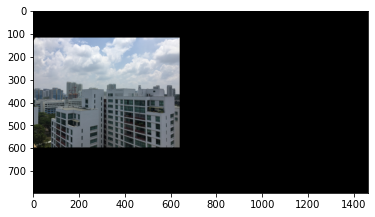

In [9]:
# im2 to im1
Hi = linalg.inv(H)

# get canvas and axis compensation
canvas,compensation = get_canvas(im1,im2,Hi)

print(compensation)
plt.imshow(canvas)

In [10]:
# transfer m2 to m1
def trans2im1(canvas,im2,Hi,compensation):
    # the wight of the im1 when overlay
    w = 0.6
    
    # step of the transmitting 1/step
    step = 2
    [row,col,c] = im2.shape
    
    # draw im2 on the canvas
    for j in range(0,row*step):
        for k in range(0,col*step):
            # positon: points of im2 in im1 plane 
            p = np.array([[j/step,k/step,1]]).T
            Tp = np.dot(Hi,p)

            # normalize and move the image
            x2 = int(round(Tp[0,0]/Tp[2,0])-compensation[0])
            y2 = int(round(Tp[1,0]/Tp[2,0])-compensation[1])
            
            # position in im1
            x1 = int(j/step)
            y1 = int(k/step)

            if np.any(canvas[x2,y2] > 0):
                canvas[x2,y2] = w * canvas[x2,y2][:] + (1 - w) * im2[x1,y1][:]
            else:
                canvas[x2,y2] = im2[x1,y1][:]
    
    return canvas.astype(int)
    

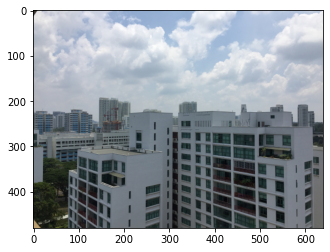

In [11]:
# show the original image
plt.imshow(im1)

In [12]:
# the image is too dark 
def interplation(image,size):
    [row,col,c] = image.shape
    
    for j in range(0,row):
        for k in range(0,col):
            # find black point
            if np.all(canvas[j,k] == 0):
                for n in range(0,c):
                    canvas[j,k,n] = np.mean(canvas[j-size:j+size+1,k-size:k+size+1,n]).astype(int)
                    
    return image
    

In [13]:
# transfer im2 to im1 plane
Tim = trans2im1(canvas,im2,Hi,compensation)

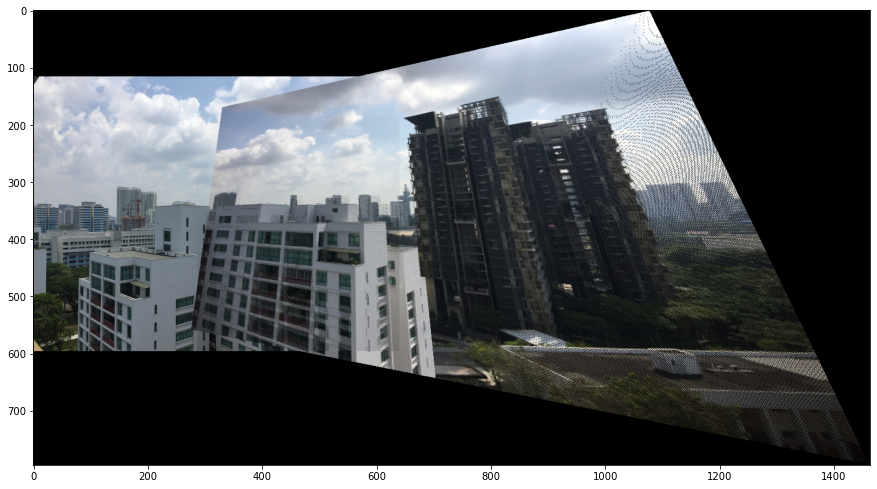

In [14]:
# show the stitched image
plt.figure( figsize=(15,15) )
plt.imshow(Tim)

/Users/wanrylin/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/wanrylin/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


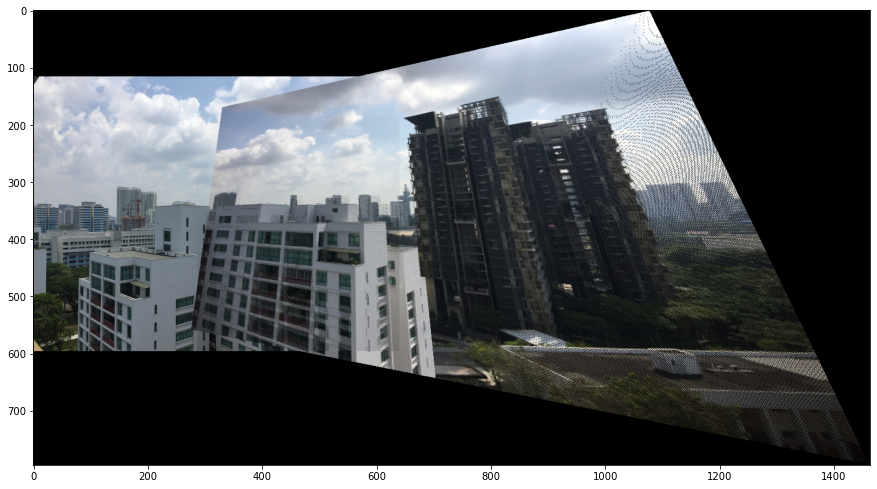

In [15]:
Tim_in = interplation(Tim,20)
plt.figure( figsize=(15,15) )
plt.imshow(Tim_in)

### 3.Explain why there is an effect of double edges in the overlapping regions between im01.jpg and im02.jpg

### Because the points we choose in im01 and im02 are not the same point in the reality. There is small error. For instance, there is a point in im01 named p1 and its corresponding point in im2 named p2. The real position of p2 in im01 is (p2x,p2y) and the computed p2 position via homography is (p2x+x_error,p2y+y_error). Therefore, the double edges appear. Actually, due to the distinguishability of image is not ifinity. So the error always exists.